Importer les Bibliothèques Nécessaires

In [226]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder ,StandardScaler
from sklearn.feature_selection import mutual_info_regression

import os
import math

Lire le jeu de données et supprimer les colonnes Id, Alley et Fence, car Id n'est pas nécessaire et Alley ainsi que Fence contiennent beaucoup de valeurs manquantes et ne sont pas utiles dans le dataset, car elles n'influencent pas beaucoup le prix


In [227]:
train = pd.read_csv("..//Housing-prices-competition//home-data-for-ml-course/train.csv")
test = pd.read_csv("..//Housing-prices-competition//home-data-for-ml-course/test.csv")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

train.columns = train.columns.astype(str).str.strip()
test.columns = test.columns.astype(str).str.strip()
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

In [228]:
print("Taille de train "  , train.shape)
print("Taille de test" , test.shape)

Taille de train  (1460, 80)
Taille de test (1459, 79)


In [229]:
print("\nNombre de features de chaque type :")
print(train.dtypes.value_counts())


Nombre de features de chaque type :
object    46
int64     34
Name: count, dtype: int64


détecter les types généraux

In [230]:
categorical_features = train.select_dtypes(include=['object']).columns
numerical_features = train.select_dtypes(include=['int64', 'float64']).columns

print("Catégorielles :", categorical_features)
print("Numériques :", numerical_features)



Catégorielles : Index(['MSZoning', 'LotFrontage', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
       'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object')
Numériques : Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath

  valeurs manquantes 

In [231]:
train.isnull().sum()


MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
Alley            0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinType2     0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual 

Vérification des types de données et conversion

In [232]:


# Convertir les colonnes contenant des nombres sous forme de texte en int ou float

train['LotFrontage'] = pd.to_numeric(train['LotFrontage'], errors='coerce') 
train['MasVnrArea'] = pd.to_numeric(train['MasVnrArea'], errors='coerce')
train['GarageYrBlt'] = pd.to_numeric(train['GarageYrBlt'], errors='coerce')


test['LotFrontage'] = pd.to_numeric(test['LotFrontage'], errors='coerce') 
test['MasVnrArea'] = pd.to_numeric(test['MasVnrArea'], errors='coerce')
test['GarageYrBlt'] = pd.to_numeric(test['GarageYrBlt'], errors='coerce')


détecter nouveaux  types généraux

In [233]:
Nv_Cat_Donnes = train.select_dtypes(include=['object']).columns
Nv_Num_Donnes = train.select_dtypes(include=['int64', 'float64']).columns
print("Catégorielles :", Nv_Cat_Donnes)
print("Numériques :", Nv_Num_Donnes)

Catégorielles : Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')
Numériques : Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',


Pourcentage de valeurs manquantes

In [234]:
missing_percentage = (train.isnull().sum() / len(train)) * 100
missing_data = missing_percentage[missing_percentage > 0]

print(missing_data)
# Les valeur Nan sur LotFrontage , GarageYrBlt , MasVnrArea , MiscFeature


LotFrontage    17.739726
MasVnrArea      0.547945
GarageYrBlt     5.547945
dtype: float64


gérer ( missing values )

In [235]:

train['LotFrontage'] = train['LotFrontage'].fillna(train['LotFrontage'].median())
train['GarageYrBlt'] = train['GarageYrBlt'].fillna(0)
train['MasVnrArea'] = train['MasVnrArea'].fillna(0)



test['LotFrontage'] = test['LotFrontage'].fillna(test['LotFrontage'].median())
test['GarageYrBlt'] = test['GarageYrBlt'].fillna(0)
test['MasVnrArea'] = test['MasVnrArea'].fillna(0)

Standardisation (scaling)

In [236]:
scaler = StandardScaler()
train[numerical_features] = scaler.fit_transform(train[numerical_features])

La coorelation

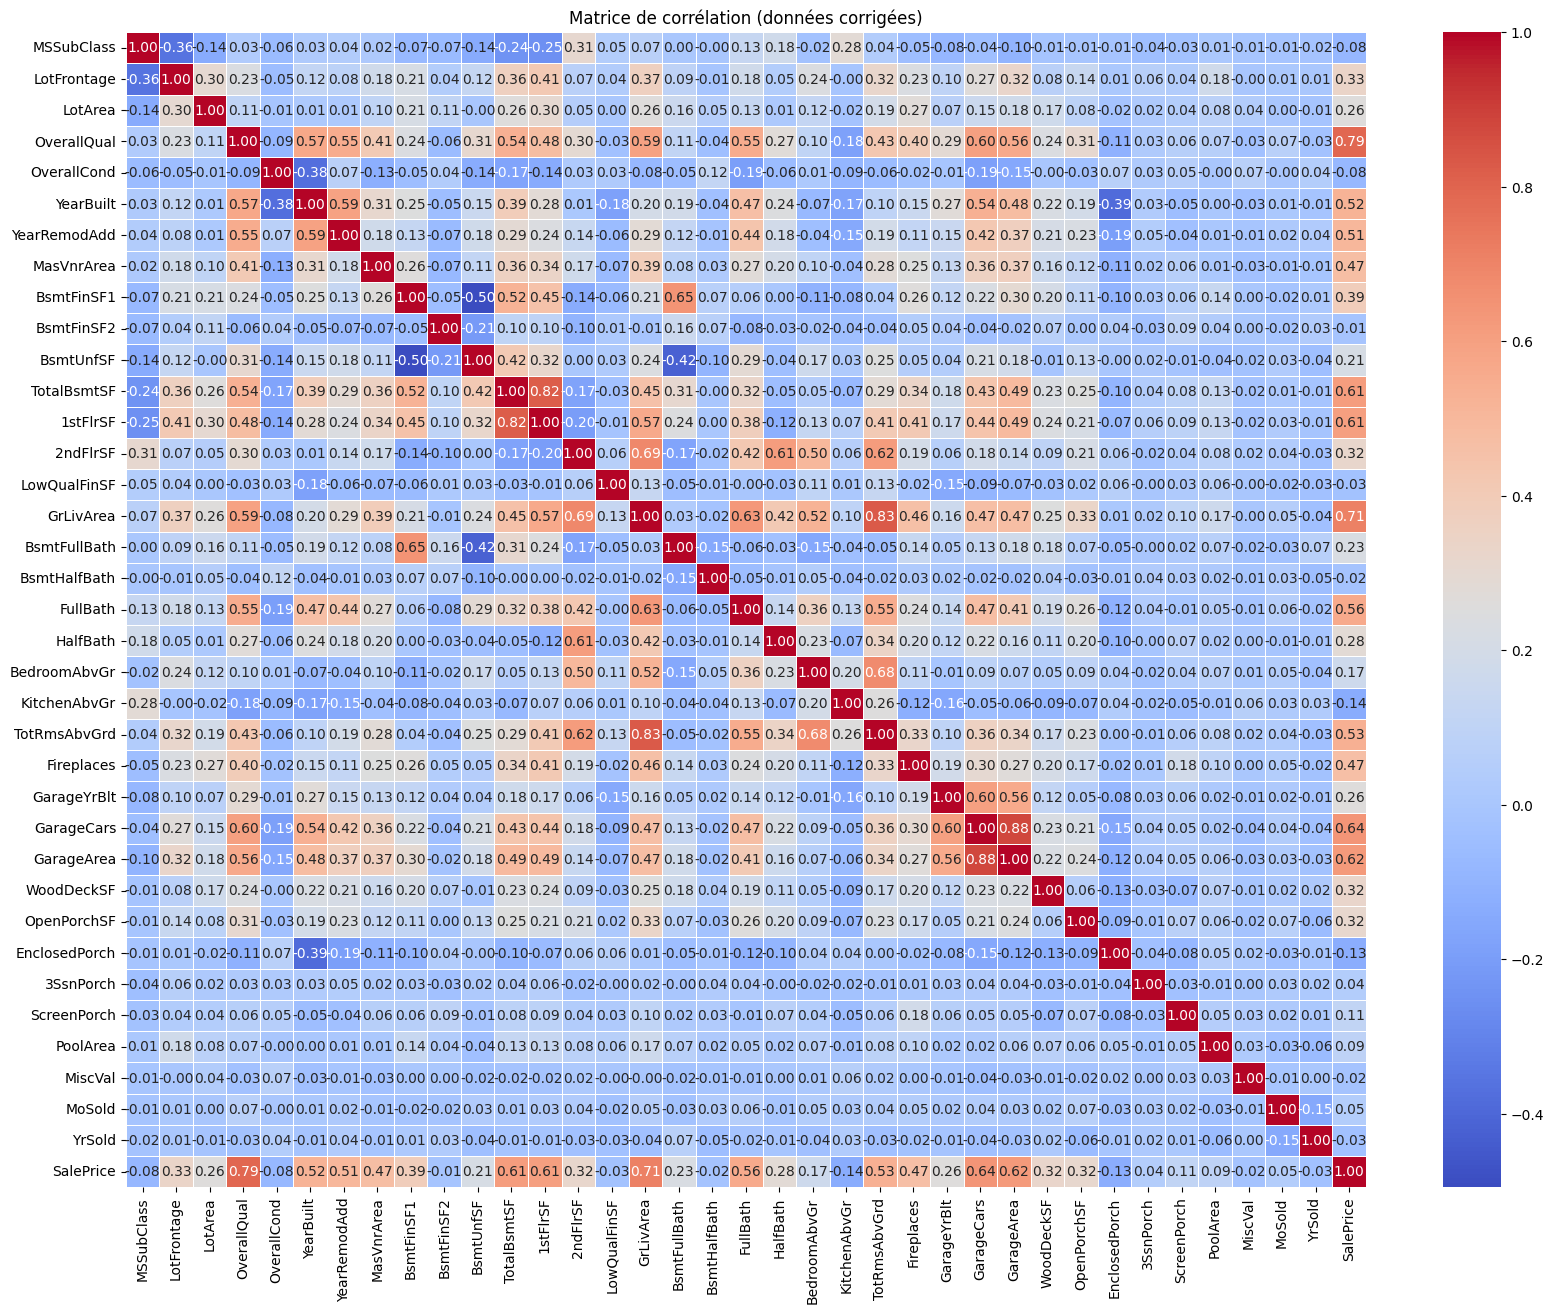

In [237]:
numeric_data = train.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_data.corr()

plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Matrice de corrélation (données corrigées)')
plt.show()

Extraction des couples de variables ayant une corrélation supérieure à 0.8

In [238]:
corr_threshold = 0.8
corr_pairs = {}

for col in correlation_matrix.columns:
    corr_pairs[col] = []
    corr_values = correlation_matrix[abs(correlation_matrix[col]) > corr_threshold][col].index.tolist()
    for pair in corr_values:
        if pair != col:
            corr_pairs[col].append(pair)

# Affichage des couples de variables ayant une corrélation supérieure à 0.8
print("Couples de variables ayant une corrélation supérieure à 0.8 :\n")
for col, pairs in corr_pairs.items():
    if len(pairs) > 0:
        for pair in pairs:
            print(col, "-", pair)

Couples de variables ayant une corrélation supérieure à 0.8 :

TotalBsmtSF - 1stFlrSF
1stFlrSF - TotalBsmtSF
GrLivArea - TotRmsAbvGrd
TotRmsAbvGrd - GrLivArea
GarageCars - GarageArea
GarageArea - GarageCars


  dropping features

In [239]:

train.drop("GarageArea", axis = 1, inplace = True)
train.drop("1stFlrSF", axis = 1, inplace = True)
train.drop("TotRmsAbvGrd", axis = 1, inplace = True)


test.drop("GarageArea", axis = 1, inplace = True)
test.drop("1stFlrSF", axis = 1, inplace = True)
test.drop("TotRmsAbvGrd", axis = 1, inplace = True)


mutual info

In [240]:
y = train.SalePrice
train_numerical = train.select_dtypes(include=["int64", "float64"]).columns.drop("SalePrice", errors="ignore")
mutual_df = train[train_numerical]


mutual_infoN = mutual_info_regression(mutual_df.fillna(0), y, random_state=1)

mutual_infoN = pd.Series(mutual_infoN)
mutual_infoN.index = mutual_df.columns
# pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ["Numerical_Feature_MI"] ).style.background_gradient("cool")
pd.DataFrame(mutual_infoN.sort_values(ascending=False), columns=["Mutual Information"]).style.background_gradient("coolwarm", axis=0)
mutual_df_categorical = train[categorical_features]
#categorical features must be encoded to get mutual information
for colname in mutual_df_categorical:
   mutual_df_categorical.loc[:, colname], _ = mutual_df_categorical[colname].factorize()
mutual_infoC = mutual_info_regression(mutual_df_categorical.fillna("Do_not_have_feature"), y, random_state=1)

mutual_infoC = pd.Series(mutual_infoC)
mutual_infoC.index = mutual_df_categorical.columns
pd.DataFrame(mutual_infoC.sort_values(ascending=False), columns = ["Categorical_Feature_MI"] ).style.background_gradient("cool")
mi_thresholdN = mutual_infoN.quantile(0.1)  # Drop bottom 10% MI features
low_mi_features = mutual_infoN[mutual_infoN < mi_thresholdN].index.tolist()
train.drop(columns=low_mi_features, inplace=True)
test.drop(columns=low_mi_features, inplace=True)


/var/folders/rg/r64x99yx2k91vgyysnwnb7pc0000gn/T/ipykernel_26716/1770775446.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mutual_infoC = mutual_info_regression(mutual_df_categorical.fillna("Do_not_have_feature"), y, random_state=1)


 Encoding des Features Ordinales et nominals

In [241]:
train_ordinal = [ 'LotShape','Utilities','LandSlope','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
                    'BsmtFinType2','HeatingQC','KitchenQual','Functional','FireplaceQu','GarageFinish','GarageQual',
                    'GarageCond','PavedDrive','PoolQC','Fence']

train_nominal = ["MSZoning", "Street", "Alley", "LandContour", "LotConfig", "Neighborhood", "Condition1", "Condition2", 
                    "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "Foundation", "Heating",
                    "CentralAir", 'Electrical',"GarageType", "MiscFeature", "SaleType", "SaleCondition"]

ordinal_mappings = {
    "LotShape": ["IR3", "IR2", "IR1", "Reg"],
    "Utilities": ["ELO", "NoSeWa", "NoSewr", "AllPub"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "ExterQual": ["Po", "Fa", "TA", "Gd", "Ex"],
    "ExterCond": ["Po", "Fa", "TA", "Gd", "Ex"],
    "BsmtQual": ["NA", "Po", "Fa", "TA", "Gd", "Ex"],
    "BsmtCond": ["NA", "Po", "Fa", "TA", "Gd", "Ex"],
    "BsmtExposure": ["NA", "No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["NA", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["NA", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "HeatingQC": ["Po", "Fa", "TA", "Gd", "Ex"],
    "KitchenQual": ["Po", "Fa", "TA", "Gd", "Ex"],
    "Functional": ["Sal", "Sev", "Maj2", "Maj1", "Mod", "Min2", "Min1", "Typ"],
    "FireplaceQu": ["NA", "Po", "Fa", "TA", "Gd", "Ex"],
    "GarageFinish": ["NA", "Unf", "RFn", "Fin"],
    "GarageQual": ["NA", "Po", "Fa", "TA", "Gd", "Ex"],
    "GarageCond": ["NA", "Po", "Fa", "TA", "Gd", "Ex"],
    "PavedDrive": ["N", "P", "Y"],
    "PoolQC": ["NA", "Fa", "TA", "Gd", "Ex"],
    "Fence": ["NA", "MnWw", "GdWo", "MnPrv", "GdPrv"]
}

# Appliquer Ordinal Encoding
train[train_ordinal] = train[train_ordinal].apply(lambda x: x.str.strip())
ordinal_encoder = OrdinalEncoder(categories=[ordinal_mappings[col] for col in train_ordinal])
train[train_ordinal] = ordinal_encoder.fit_transform(train[train_ordinal])


# Appliquer Nominal Encoding

one_hot_encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

encoded_nominal = one_hot_encoder.fit_transform(train[train_nominal])
# Convertir en DataFrame Pandas
encoded_nominal_df = pd.DataFrame(encoded_nominal, columns=one_hot_encoder.get_feature_names_out(train_nominal))

# Supprimer les anciennes colonnes nominales et ajouter les nouvelles colonnes encodées
train = train.drop(columns=train_nominal).reset_index(drop=True)
train = pd.concat([train, encoded_nominal_df], axis=1)

final Data

In [242]:
train.to_csv('final_data.csv', index=False)